In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [3]:
brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

## Prediction

In [4]:
def merge_duration_and_weather(duration, weather):
    return duration.merge(how="left", left_on=["day", "hour"], right_on=["day","hour"], right=weather)

def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame
    
#def split_weekday(frame):
#    frame = add_weekday(frame)
#    weekdays = [None]*7
#    for i in range(0,6):
#        weekdays[i] = frame[frame["weekday"]==i]
#    return weekdays

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test

regression models:

In [52]:
def linear_regression(input):

    model = LinearRegression()
    model.fit(input[0], input[2])
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(input[1])
    print("MSE: ", mean_squared_error(input[3], predict))
    print ("R^2: " ,r2_score(input[3], predict))


def polynomial_regression(input, degree):

    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])
    model.fit(x_poly, input[2])

    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)
    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return {"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred}


def ridge_regression(input, degree, alpha):

    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Ridge(alpha, normalize=True)
    model.fit(x_poly, input[2])
    predict = model.predict(x_poly_test)

    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return mse, r2



def lasso_regression(input, degree, alpha):

    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Lasso(alpha)
    model.fit(x_poly, input[2])
    print("Coefficients ", model.coef_, "\nIntercept ", model.intercept_ )
    predict = model.predict(x_poly_test)
    print("MSE:", mean_squared_error(input[3], predict))
    print ("R^2: " ,r2_score(input[3], predict))

In [102]:
frb_hourly = merge_duration_and_weather(frb_hourly_driven, frb_hourly_weather)
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])

brm_hourly = merge_duration_and_weather(brm_hourly_driven, brm_hourly_weather)
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])

frb_weekdays = add_weekday(frb_hourly)
brm_weekdays = add_weekday(brm_hourly)

Visualization of the four features for the regression

In [7]:
def visualize_features(frame):
    trip_duration = frame["trip_duration"]
    f1 = frame["temperature"]
    f2 = frame["precipitation"]
    f3 = frame["hour"]
    f4 = frame["weekday"]

    fig = plt.figure(figsize = (12,4))
    ax = fig.add_subplot(2,2,1)
    ax.scatter(f1,trip_duration, marker='x')
    ax.set_xlabel("High Temperature (°C)")
    ax.set_ylabel("Trip Duration (min)")
    bx =  fig.add_subplot(2,2,2)
    bx.scatter(f2,trip_duration, marker='x')
    bx.set_xlabel("Precipitation (mm)")
    bx.set_ylabel("Trip Duration (min)")
    cx =  fig.add_subplot(2,2,3)
    cx.scatter(f3,trip_duration, marker='x')
    cx.set_xlabel("Hour of day")
    cx.set_ylabel("Trip Duration (min)")
    dx =  fig.add_subplot(2,2,4)
    dx.scatter(f4,trip_duration, marker='x')
    dx.set_xlabel("Weekday")
    dx.set_ylabel("Trip Duration (min)")
    plt.show()

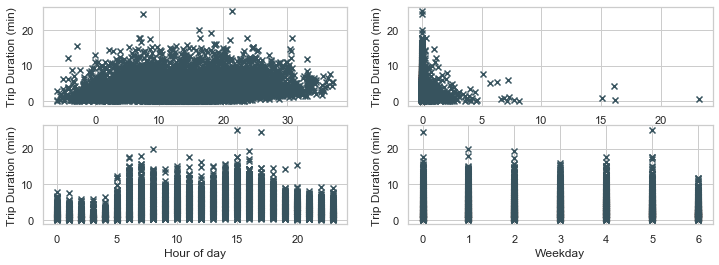

In [8]:
visualize_features(frb_hourly)

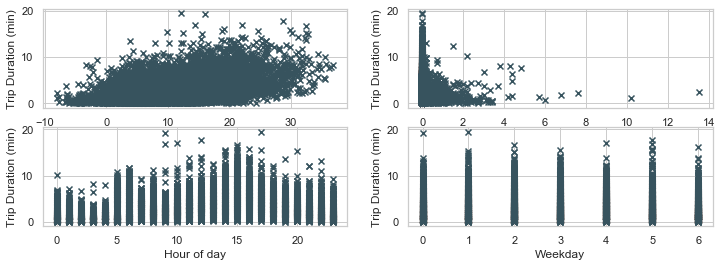

In [9]:
visualize_features(brm_hourly)

In [10]:
#Split

features = frb_hourly[["precipitation", "temperature", "hour", "weekday"]]
predictor = frb_hourly["trip_duration"]


In [61]:
test_split = train_test_split(features, predictor, test_size=0.4)

In [12]:
###  Linear regression

In [13]:
linear_regression(test_split)

Coefficients  [-0.40519533  0.0347822   0.09688005 -0.17829349] 
Intercept  2.812062892753256
MSE:  9.010116278642707
R^2:  0.05507706722173


### Polynomial regression


To ensure that multiple features actually decrease the medium squared error we ploted a graph


In [ ]:
features=[]
features.append(np.array(frb_hourly["temperature"]).reshape(-1,1))
features.append(frb_hourly[["temperature", "hour"]])
features.append(frb_hourly[["temperature", "hour", "weekday"]])
features.append(frb_hourly[["temperature", "hour", "weekday", "precipitation"]])

mse_array = []
r2_array = []

def custom_split(x_array, y_array, end):
    return x_array[:end], x_array[end:], y_array[:end], y_array[end:]

for i in range(0, 4):
    split = custom_split(features[i], predictor, 5000)
    out = polynomial_regression(split, 3)
    mse_array.append(out["mse"])
    r2_array.append(out["r2"])


print(mse_array)
print(r2_array)

x_values = [0,1,2,3]

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.plot(x_values, r2_array)

bx = fig.add_subplot(1,2,2)
bx.plot(x_values, mse_array)




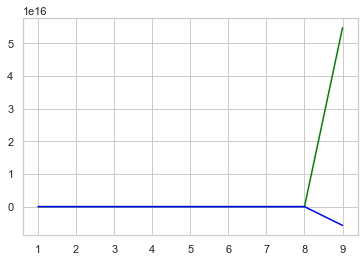

In [50]:
mse_array = []
r2_array = []
degree_array = []

degree = 1
while degree < 10:
    obj = polynomial_regression(test_split, degree)
    degree_array.append(degree)
    r2_array.append(obj["r2"])
    mse_array.append(obj["mse"])
    degree += 1


plt.plot(degree_array, mse_array, c="green")
plt.plot(degree_array, r2_array, c="blue")


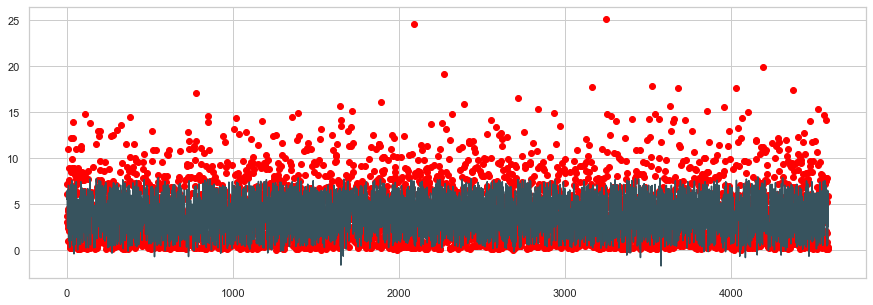

In [60]:
out = polynomial_regression(test_split, 6)

plt.figure(figsize=(15, 5))
plt.scatter(range(0,len(out["y_train"])), out["y_train"], c="red")
plt.plot(range(0,len(out["y_train"])), out["y_pred"])



### Ridge regression

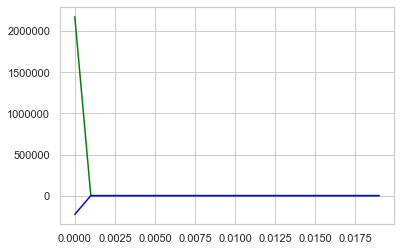

In [28]:
mse_array = []
r2_array = []
alpha_array = []

alpha = 0
while alpha < 0.02:
    mse, r2 = ridge_regression(test_split, 6, alpha)
    alpha_array.append(alpha)
    r2_array.append(r2)
    mse_array.append(mse)
    alpha += 0.001


plt.plot(alpha_array, mse_array, c="green")
plt.plot(alpha_array, r2_array, c="blue")



### Lasso regression

In [16]:
ridge_regression(test_split, 3, 0.01)

(6.79722315008476, 0.2871510383333269)

### Lasso regression

In [17]:
ridge_regression(features, predictor, 3, 0.01)

TypeError: ridge_regression() takes 3 positional arguments but 4 were given

Split the data set into traing(60%), validation(20%), test(20%) setst to prevent leakage.

In [35]:
x_train, x_validate, x_test = np.split(brm_hourly['temperature'].sample(frac=1), [int(.6*len(brm_hourly['temperature'])), int(.8*len(brm_hourly['temperature']))])
y_train, y_validate, y_test = np.split(brm_hourly['trip_duration'].sample(frac=1), [int(.6*len(brm_hourly['trip_duration'])), int(.8*len(brm_hourly['trip_duration']))])

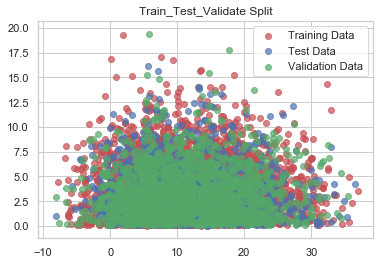

In [36]:
plt.scatter(x_train, y_train, label = "Training Data", color = "r", alpha =.7)
plt.scatter(x_test, y_test, label = "Test Data", color = "b", alpha =.7)
plt.scatter(x_validate, y_validate, label = "Validation Data", color = "g", alpha =.7)
plt.legend()
plt.title("Train_Test_Validate Split")
plt.show()

In [37]:
#Create linear model and train it 
lr = LinearRegression()
lr.fit(x_train.values.reshape(-1, 1), y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

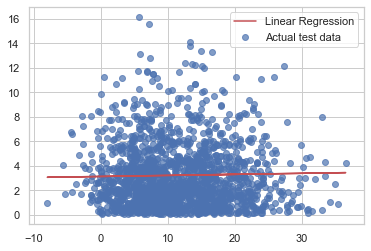

In [38]:
# Use model to predict on test data
prediction = lr.predict(x_test.values.reshape(-1, 1))

# Plot prediction line against actual test data 
plt.plot(x_test, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_test, y_test, label='Actual test data', color = 'b', alpha=.7)
plt.legend()
plt.show()

The best score that we could achieve for a model is 1.0. 
~Soo our linear model is not that great...

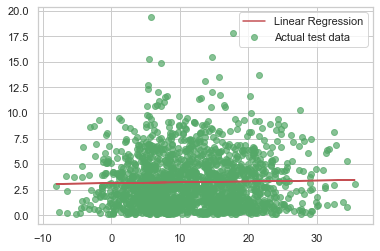

In [39]:
# Plot prediction line against actual test data 
prediction = lr.predict(x_validate.values.reshape(-1, 1))
plt.plot(x_validate, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_validate, y_validate, label='Actual test data', color = 'g', alpha=.7)
plt.legend()
plt.show()

In [40]:
# Score the model 
lr.score(x_validate.values.reshape(-1, 1), y_validate.values)

0.0007530740871903862

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [42]:
y_true = y_validate
y_pred = lr.predict(x_validate.values.reshape((-1,1)))

In [44]:
print("Mean Squared Error:",mean_squared_error(y_pred, y_true))
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5)
print("Coefficient of determination:",r2_score(y_true, y_pred))

Mean Squared Error: 6.709722963405456
Root Mean Squared Error: 2.5903132944502016
Coefficient of determination: 0.0007530740871903863


### Polynomial  regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

In [ ]:
xp = x_train.values

yp = y_train 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_test.values

yp = y_test 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_validate.values

yp = y_validate 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
plot_regression_poly

### Idea

Split dataset into train_test_validate sets not for every hour individually but rather hourly.